# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from glob import glob as glob
from pathlib import Path

from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn  as sns

from sklearn.metrics import confusion_matrix, classification_report

# Getting Images

In [2]:
processed_crackdir = Path("../data/processed/pro_crack_img")
processed_noncrackdir = Path("../data/processed/pro_noncrack_img")

# ogcrack_dir = Path("../data/external/Crack")
# ognoncrack_dir = Path("../data/external/Non-crack")

def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [3]:
crack_df = generate_df(processed_crackdir, label="CRACK_IMAGE")
noncrack_df = generate_df(processed_noncrackdir,label="NONCRACK_IMAGE")

# crack_df = generate_df(ogcrack_dir, label="CRACK_IMAGE")
# noncrack_df = generate_df(ognoncrack_dir,label="NONCRACK_IMAGE")

crack_sample = crack_df.sample(n=10000, random_state=42)
noncrack_sample = noncrack_df.sample(n=10000, random_state=42)

total_df = pd.concat([crack_sample, noncrack_sample], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

print(total_df)

                                           Filepath           Label
0      ..\data\processed\pro_noncrack_img\00317.jpg  NONCRACK_IMAGE
1         ..\data\processed\pro_crack_img\01288.jpg     CRACK_IMAGE
2         ..\data\processed\pro_crack_img\04037.jpg     CRACK_IMAGE
3         ..\data\processed\pro_crack_img\01278.jpg     CRACK_IMAGE
4      ..\data\processed\pro_noncrack_img\04672.jpg  NONCRACK_IMAGE
...                                             ...             ...
19995  ..\data\processed\pro_noncrack_img\05677.jpg  NONCRACK_IMAGE
19996  ..\data\processed\pro_noncrack_img\09195.jpg  NONCRACK_IMAGE
19997     ..\data\processed\pro_crack_img\06265.jpg     CRACK_IMAGE
19998     ..\data\processed\pro_crack_img\09116.jpg     CRACK_IMAGE
19999  ..\data\processed\pro_noncrack_img\03766.jpg  NONCRACK_IMAGE

[20000 rows x 2 columns]


# Test-Train split

In [4]:
train_df, test_df = train_test_split(
    total_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

train_df

,Filepath,Label
7370,..\data\processed\pro_crack_img\05324.jpg,CRACK_IMAGE
12350,..\data\processed\pro_crack_img\05288.jpg,CRACK_IMAGE
11872,..\data\processed\pro_crack_img\08533.jpg,CRACK_IMAGE
19890,..\data\processed\pro_crack_img\09378.jpg,CRACK_IMAGE
11130,..\data\processed\pro_noncrack_img\09248.jpg,NONCRACK_IMAGE
...,...,...
13993,..\data\processed\pro_crack_img\05183.jpg,CRACK_IMAGE
2694,..\data\processed\pro_noncrack_img\01044.jpg,NONCRACK_IMAGE
18896,..\data\processed\pro_noncrack_img\04946.jpg,NONCRACK_IMAGE
11749,..\data\processed\pro_crack_img\04562.jpg,CRACK_IMAGE


# Loading/Adding Images

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                # rescale = 1./255,
                validation_split = 0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                # rescale = 1./255
)


In [13]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=24,
    shuffle=True,   
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=24,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=24,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


# Training

# Custom CNN 

In [14]:
# inputs = tf.keras.Input(shape=(120, 120, 3))
# x = tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu')(inputs)
# x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.Conv2D(filters=24, kernel_size=(3, 3), activation='relu')(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# print(model.summary())

inputs = tf.keras.Input(shape=(96, 96, 1))

x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,329 (6.60 MB)

 Trainable params: 1,731,329 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

c:\Users\saiprasath\ML-Surface-Crack-Detection\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 88s 573ms/step - accuracy: 0.8657 - loss: 0.3914 - val_accuracy: 0.9786 - val_loss: 0.1183
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 278ms/step - accuracy: 0.9754 - loss: 0.1035 - val_accuracy: 0.9893 - val_loss: 0.0618
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 64s 459ms/step - accuracy: 0.9887 - loss: 0.0718 - val_accuracy: 0.9905 - val_loss: 0.0654
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 71s 378ms/step - accuracy: 0.9874 - loss: 0.0533 - val_accuracy: 0.9810 - val_loss: 0.0797
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 356ms/step - accuracy: 0.9914 - loss: 0.0429 - val_accuracy: 0.9952 - val_loss: 0.0482
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 48s 342ms/step - accuracy: 0.9951 - loss: 0.0379 - val_accuracy: 0.9857 - val_loss: 0.0758
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 367ms/step - accuracy: 0.9951 - loss: 0.0396 - val_accuracy: 0.9929 - val_loss: 0.0438
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 351ms/step - accuracy: 0.9944 -

In [16]:
print(history.history.keys())

fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)
fig.show(renderer='browser')

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


c:\Users\saiprasath\ML-Surface-Crack-Detection\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



    Test Loss: 0.04463
Test Accuracy: 99.28%
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step


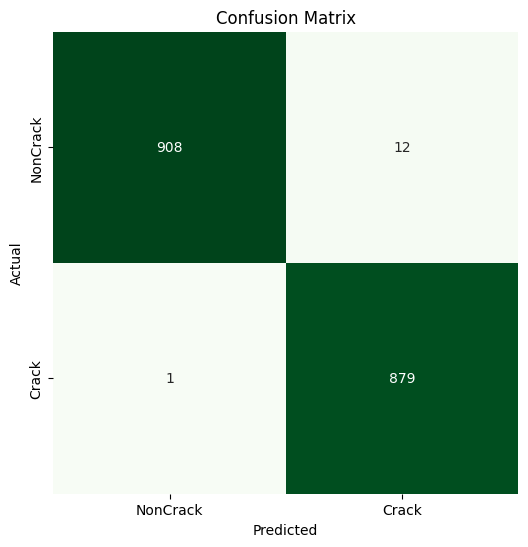

Classification Report:
----------------------
               precision    recall  f1-score   support

   Non-Crack       1.00      0.99      0.99       920
       Crack       0.99      1.00      0.99       880

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



In [17]:
results = model.evaluate(test_data, verbose=0)
loss = results[0]
acc = results[1]
    
print("    Test Loss: {:.5f}".format(loss))
print("Test Accuracy: {:.2f}%".format(acc * 100))
    
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
cm = confusion_matrix(test_data.labels, y_pred)
clsrpt = classification_report(test_data.labels, y_pred, target_names=["Non-Crack", "Crack"])
clr = classification_report(test_data.labels, y_pred, target_names=["Non-Crack", "Crack"],output_dict=True)
    
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NonCrack", "Crack"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NonCrack", "Crack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
    
print("Classification Report:\n----------------------\n", clsrpt)

# Logging Model to MLflow

In [18]:
import dagshub
dagshub.init(repo_owner='Saipr14', repo_name='ML-Surface-Crack-Detection', mlflow=True)

Accessing as Saipr14

Initialized MLflow to track repo "Saipr14/ML-Surface-Crack-Detection"

Repository Saipr14/ML-Surface-Crack-Detection initialized!

In [19]:
import mlflow
import mlflow.keras
from mlflow.models import infer_signature

mlflow.set_experiment("Surface Crack Detection Experiments")
mlflow.set_tracking_uri("https://dagshub.com/Saipr14/ML-Surface-Crack-Detection.mlflow")

params = {
    "Model_name": "Preprocessed CNN Model",
    "optimizer": "adam",
    "loss_function": "binary_crossentropy",
    "metrics": "accuracy", 
    "batch_size": 24, 
    "epochs": 11
}

with mlflow.start_run(run_name="Preprocess Custom CNN"):
    mlflow.log_params(params)
    mlflow.log_metrics({
        'accuracy': clr['accuracy'],
        'precision': clr['Crack']['precision'],  # Get precision for 'Crack' class
        'recall': clr['Crack']['recall'],  # Get recall for 'Crack' class
        'f1-score': clr['Crack']['f1-score']  # Get F1-score for 'Crack' class
    })

    example_input, _ = next(train_data)
    example_input = np.array(example_input[:1])
    example_output = model.predict(example_input)

    signature = infer_signature(example_input, example_output)

    mlflow.keras.log_model(model, "model", signature=signature)

    print("Metrics and Model Logged in MLflow Successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
Metrics and Model Logged in MLflow Successfully!
🏃 View run Preprocess Custom CNN at: https://dagshub.com/Saipr14/ML-Surface-Crack-Detection.mlflow/#/experiments/1/runs/6d5ff4fd363944b8a371f8eafe88fe7c
🧪 View experiment at: https://dagshub.com/Saipr14/ML-Surface-Crack-Detection.mlflow/#/experiments/1


# CNN Model Trained and Logged

## Registering the model for deployment

In [20]:
model_name = input("Enter the model's name: ")
run_id = input("Enter the run_id: ")
model_uri = f"runs:/{run_id}/model"
result = mlflow.register_model(
    model_uri, model_name
)

Registered model 'Preprocess Custom CNN' already exists. Creating a new version of this model...
2025/05/15 00:14:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Preprocess Custom CNN, version 2
Created version '2' of model 'Preprocess Custom CNN'.
